In [12]:
%load_ext autoreload
%autoreload 2

## IMPORT LIBRARIES

In [3]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
print('Seed: 42')




Seed: 42


## DATA PROCESSING

In [4]:
# https://drive.google.com/file/d/16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju/view?usp=sharing
!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
DATA_PATH = '../cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10

raw = pd.read_csv(DATA_PATH, header=None, names=COLUMNS)
for c in ['age', 'trestbps', 'chol', 'thal', 'oldpeak', 'ca', 'thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] > 0).astype(int)
print('Shape:', raw.shape)
display(raw.head())
display(raw.isna().sum())


Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

## DATA POST-PROCESSING

In [6]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler()),
])

num_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols ),
    ('cat', cat_proc, categorical_cols),
])

raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)


## Processed DataSet (Raw DataSet)

In [7]:
preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

X_raw_train_df = pd.DataFrame(
    X_raw_train, columns=preprocessed_feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(
    X_raw_val, columns=preprocessed_feature_names, index=X_val.index)
X_raw_test_df = pd.DataFrame(
    X_raw_test, columns=preprocessed_feature_names, index=X_test.index)

out_dir = Path('../splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_test.csv', index=False)

print('Saved raw dataset')
display(X_raw_train_df)


Saved raw dataset


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
180,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0
208,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0
167,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0
105,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0
297,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.829818,0.514117,2.733557,0.310836,0.179210,0.0,1.000000,0.0,1.0,0.0,0.5,0.000000,0.0
136,1.720848,0.798433,-1.438042,-1.102621,1.428521,1.0,1.000000,0.0,0.0,1.0,1.0,0.000000,1.0
2,1.386712,-0.623144,-0.395142,-0.925938,1.428521,1.0,1.000000,0.0,1.0,1.0,0.5,0.666667,1.0
189,1.609469,0.514117,0.078903,-0.175039,0.893102,1.0,0.666667,0.0,1.0,0.0,0.5,1.000000,1.0


## DECISION TREE FEATURE SELECTION

In [8]:
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
])

dt_feature_selection_pipeline.fit(X_train, y_train)
feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=preprocessed_feature_names
)

sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

thal        0.292921
cp          0.126362
ca          0.118425
oldpeak     0.109681
chol        0.097347
age         0.074188
thalach     0.073157
sex         0.033909
slope       0.025014
exang       0.015216
trestbps    0.014364
fbs         0.011095
restecg     0.008321
dtype: float64

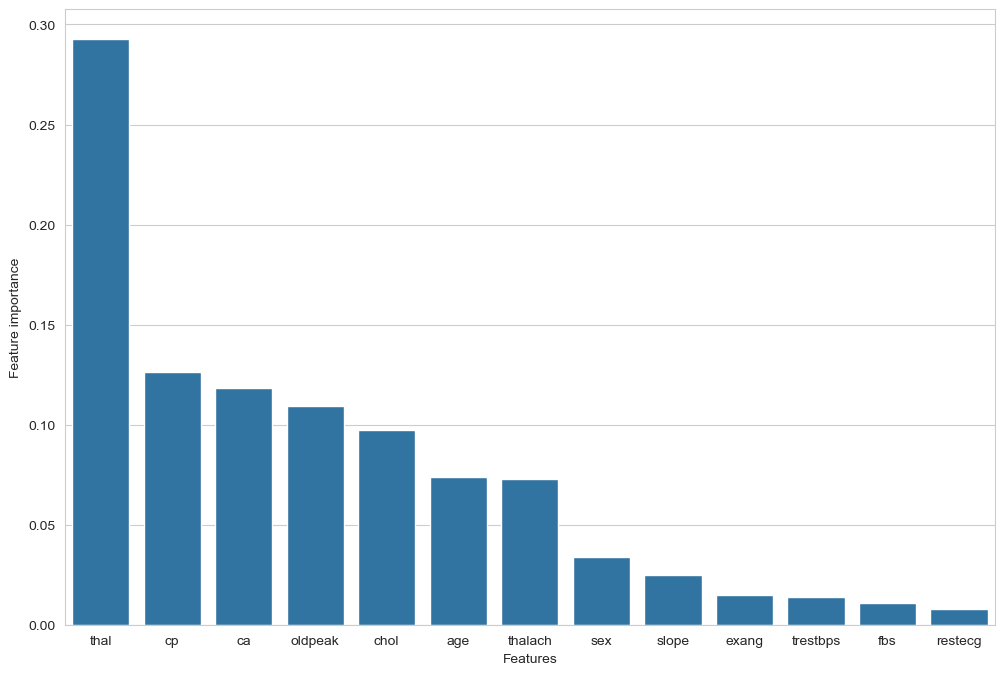

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(
    y=sorted_feature_importances.values,
    x=sorted_feature_importances.index,
)
plt.ylabel('Feature importance')
plt.xlabel('Features')
plt.show()


In [10]:
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} features: {selected_features}')

X_dt_train = X_raw_train_df[selected_features]
X_dt_val = X_raw_val_df[selected_features]
X_dt_test = X_raw_test_df[selected_features]
display(X_dt_train)

pd.concat([X_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

print(f"Saved RAW_DT splits. K (RAW_DT features) = {K_features}")

Top 10 features: ['thal', 'cp', 'ca', 'oldpeak', 'chol', 'age', 'thalach', 'sex', 'slope', 'exang']


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang
180,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0
208,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0
167,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0
105,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0
297,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...
173,0.0,1.000000,0.000000,0.179210,2.733557,0.829818,0.310836,0.0,0.5,0.0
136,1.0,1.000000,0.000000,1.428521,-1.438042,1.720848,-1.102621,1.0,1.0,1.0
2,1.0,1.000000,0.666667,1.428521,-0.395142,1.386712,-0.925938,1.0,0.5,1.0
189,1.0,0.666667,1.000000,0.893102,0.078903,1.609469,-0.175039,1.0,0.5,0.0


Saved RAW_DT splits. K (RAW_DT features) = 10


## FEATURE ENGINEERING

In [11]:
def add_new_features_func(df):
 df = df.copy()
 if {'chol','age'} <= set(df.columns):
    df['chol_per_age'] = df['chol']/df['age']
 if {'trestbps','age'} <= set(df.columns):
    df['bps_per_age'] = df['trestbps']/df['age']
 if {'thalach','age'} <= set(df.columns):
    df['hr_ratio'] = df['thalach']/df['age']
 if 'age' in df.columns:
    df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
 return df

class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __inti__(self):
        pass
    def fit(self, X, y=None):
        self.columns = X.columns
        self.new_features = []
        if {'chol','age'} <= set(X.columns):
            self.new_features.append('chol_per_age')
        if {'trestbps','age'} <= set(X.columns):
            self.new_features.append('bps_per_age')
        if {'thalach','age'} <= set(X.columns):
            self.new_features.append('hr_ratio')
        if 'age' in X.columns:
            self.new_features.append('age_bin')
        return self
    def transform(self, X, y=None):
        return add_new_features_func(X)

    def get_feature_names_out(self, input_features=None):
        return list(self.columns) + self.new_features

gen_num = ['chol_per_age', 'bps_per_age', 'hr_ratio']
gen_cat = ['age_bin']
all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

num_proc = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
])

cat_proc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')





In [12]:
Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]


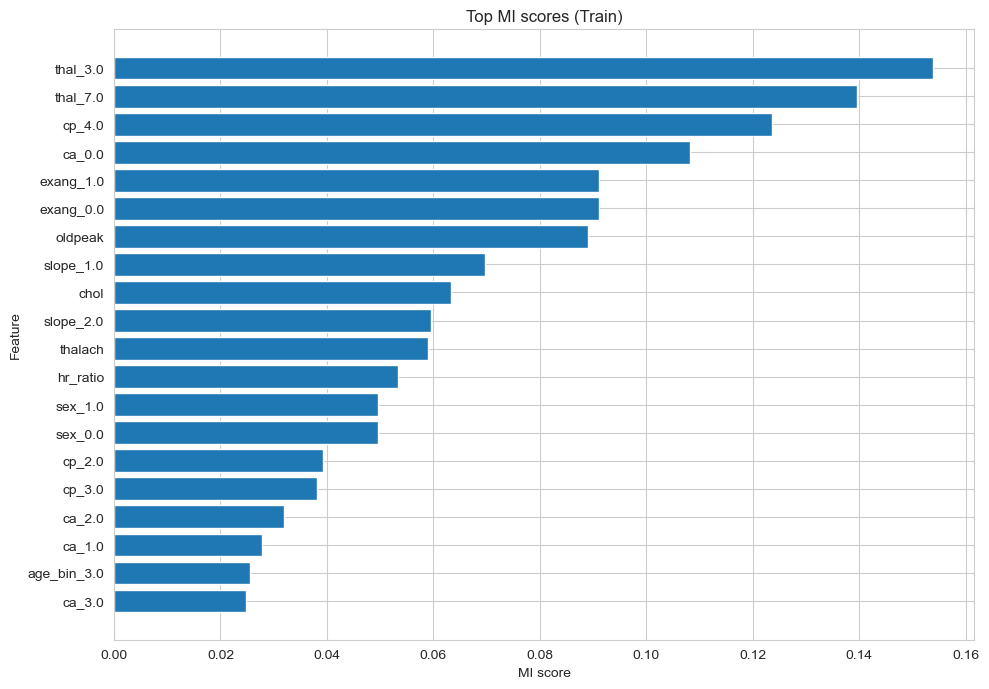

0      thal_3.0
1      thal_7.0
2        cp_4.0
3        ca_0.0
4     exang_1.0
5     exang_0.0
6       oldpeak
7     slope_1.0
8          chol
9     slope_2.0
10      thalach
11     hr_ratio
12      sex_1.0
Name: fe_topk_features, dtype: object

In [13]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))

is_discrete = np.array(
    [c in cat_names for c in Xt_tr.columns],
    dtype=bool
)

mi = mutual_info_classif(
    Xt_tr.values, y_train.values,
    discrete_features=is_discrete,
    random_state=42
)

mi_series = pd.Series(
    mi, index=Xt_tr.columns
).sort_values(ascending=False)

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]

plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)

fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

out = Path('../splits')
out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out/'fe_train.csv', index=False)
fe_va.to_csv(out/'fe_val.csv', index=False)
fe_te.to_csv(out/'fe_test.csv', index=False)

display(pd.Series(topk_cols, name='fe_topk_features').reset_index(drop=True))


In [14]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

dt_fe_feature_selection_pipeline.fit(X_train, y_train)

pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()

feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)

sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]

display(X_fe_dt_train.head())

pd.concat([X_fe_dt_train, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_train.csv', index=False)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_test.csv', index=False)


Top 10 selected features: ['thal_3.0', 'cp_4.0', 'ca_0.0', 'chol_per_age', 'hr_ratio', 'oldpeak', 'chol', 'age', 'exang_0.0', 'cp_3.0']


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0
180,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0
208,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0
167,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0
105,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0
297,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0


In [15]:
# SMOTE oversampling on training set (creates new balanced datasets)
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    raise ImportError("Please install imbalanced-learn: pip install imbalanced-learn")
from collections import Counter

# Apply SMOTE on feature-engineered Top-K features
X_in = Xt_tr[topk_cols]
y_in = y_train
min_count = min(Counter(y_in).values())
k_neighbors = 5 if min_count > 5 else max(1, min_count - 1)
sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = sm.fit_resample(X_in, y_in)
fe_tr_smote = pd.DataFrame(X_res, columns=X_in.columns).assign(target=y_res.values)
fe_tr_smote.to_csv(out/'smote_fe_train.csv', index=False)

# Smote khong dung tren val va test
pd.concat([X_fe_dt_val, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'smote_fe_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'smote_fe_test.csv', index=False)

print('Saved fe_train_smote.csv')
print('Class counts before:', Counter(y_in))
print('Class counts after :', Counter(y_res))

Saved fe_train_smote.csv
Class counts before: Counter({0: 131, 1: 111})
Class counts after : Counter({1: 131, 0: 131})


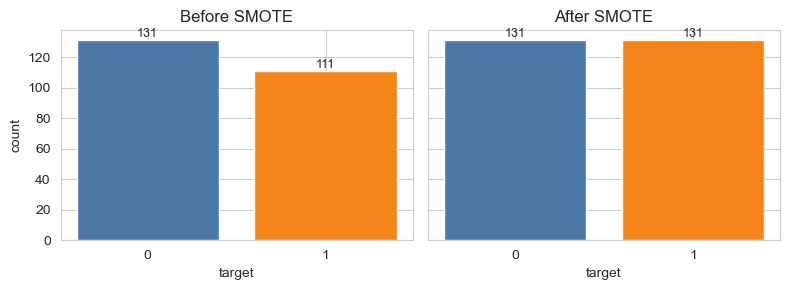

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

paths = ['../splits/fe_dt_train.csv', '../splits/smote_fe_train.csv']  # thay theo nhu cầu
titles = ['Before SMOTE', 'After SMOTE']

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
for ax, p, t in zip(axes, paths, titles):
    df = pd.read_csv(p)
    counts = df['target'].value_counts().reindex([0, 1], fill_value=0)
    ax.bar(['0', '1'], counts.values, color=['#4c78a8', '#f58518'])
    ax.set_title(t)
    ax.set_xlabel('target')
    for i, v in enumerate(counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('count')
plt.tight_layout()
plt.show()
